# Mouting the Google Drive

It is possible to mount your Google Drive to Colab if you need additional storage or if you need to use files from it. To do that run (click on play button or use keyboard shortcut 'Command/Ctrl+Enter') the following code cell:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install dependencies



In [ ]:
!pip install bertopic dask 'fsspec>=0.3.3' dask_ml aiohttp

# Load packages

In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask_ml
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import figure
import matplotlib.dates as mdates

# Loading the Data
We use dask to handle the data that are larger than memory.
This library makes lazy computation on the data (building a computation graph) and loads data by block that can fit the memory. 
This allow us to do pandas like operation on the whole dataset.


## Uncompress
Dask need to work on uncompressed data to be able to read data by block

To do this, one can run this code : 


```
year = 2018
path_new_file = '/content/drive/MyDrive/ADA/quotes-{year}.json'.format(year=year)
path_old_file = '/content/drive/MyDrive/ADA/quotes-{year}.json.bz2'.format(year=year)
i=0
with bz2.open(path_old_file, 'rb') as s_file:
    with open(path_new_file, 'wb') as d_file:
      for instance in s_file:
        d_file.write(instance)
        print(i++)
```





## Load the files

In [ ]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

path_new_file = '/content/drive/MyDrive/ADA/quotes-{year}.json'
data_path = path_new_file.format(year="*")

qu = dd.read_json(data_path, 
                  blocksize=2**27,
                  meta={'quoteID': 'object', 'quotation': 'object', 'speaker': 'object', 'qids': 'object', 'date': 'datetime64[ns]', 'numOccurrences': 'int64', 'probas': 'object', 'urls': 'object', 'phase': 'object'}
                  )

In [ ]:
qu.head()

[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.6s


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E
7,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,[Q5268447],2020-01-17 13:03:00,1,"[[Dexter Smith, 0.924], [None, 0.076]]",[http://www.sloughexpress.co.uk/gallery/slough...,E
8,2020-04-02-000239,[ The scheme ] treats addiction as an illness ...,Barry Coppinger,[Q4864119],2020-04-02 14:18:20,1,"[[Barry Coppinger, 0.9017], [None, 0.0983]]",[http://www.theweek.co.uk/106479/why-police-ar...,E
9,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,[Q816459],2020-03-19 19:14:00,1,"[[Ben Carson, 0.9227], [None, 0.0773]]",[https://mortgageorb.com/hud-fha-suspend-forec...,E


# Data Cleaning and Pre-Processing


### Remove duplicates

In [ ]:
#qu = qu.drop_duplicates(subset=['quoteID'])
#this is too intensive, we should try to index the dataset on quotes id and then we will be sure we have no duplicates, and we have a nice index (by dates - quotes number)

### No quotes with unkown speakers
We want to work on citation with known authors, so we filter out citations with unknown authors.

In [ ]:
qu = qu[qu.speaker != "None"]


### Wikipedia QID
We want to have a field with a single wikipedia QID. We keep the first. This will allow us to do a join with the additional wikipedia dataset.

In [ ]:
def parse_qids(row):
  row.qids = row.qids[0] if len(row.qids) > 0 else None
  return row

qu = qu.apply(parse_qids, axis=1)#, meta={'quoteID': 'string', 'quotation': 'string', 'speaker': 'string', 'qids': 'string', 'date': 'datetime64[ns]', 'numOccurrences': 'int64', 'probas': 'object', 'urls': 'object', 'phase': 'string'})

/usr/local/lib/python3.7/dist-packages/dask/dataframe/core.py:4150: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta={'quoteID': 'object', 'quotation': 'object', 'speaker': 'object', 'qids': 'object', 'date': 'datetime64[ns]', 'numOccurrences': 'int64', 'probas': 'object', 'urls': 'object', 'phase': 'object'})

  warnings.warn(meta_warning(meta))


### Display cleaned data


In [ ]:
qu.head()

[########################################] | 100% Completed | 10.1s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.3s


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E
7,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,[Q5268447],2020-01-17 13:03:00,1,"[[Dexter Smith, 0.924], [None, 0.076]]",[http://www.sloughexpress.co.uk/gallery/slough...,E
8,2020-04-02-000239,[ The scheme ] treats addiction as an illness ...,Barry Coppinger,[Q4864119],2020-04-02 14:18:20,1,"[[Barry Coppinger, 0.9017], [None, 0.0983]]",[http://www.theweek.co.uk/106479/why-police-ar...,E
9,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,[Q816459],2020-03-19 19:14:00,1,"[[Ben Carson, 0.9227], [None, 0.0773]]",[https://mortgageorb.com/hud-fha-suspend-forec...,E


# Let's Exercise a bit
Let's make a small exercise to demonstrate dask abilities : 
##Trumps citations found a least two times
We want to find the quotes of donald trump that have been seen more than once.

In [ ]:
trump = qu[(qu.speaker.str.lower().str.contains("trump")) & (qu.numOccurrences > 1)]
trump.head()

[########################################] | 100% Completed | 10.3s
[########################################] | 100% Completed | 10.3s


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
247,2020-02-19-010736,But I happen to like Prime Minister (Narendra)...,Donald Trump,"[Q22686, Q27947481]",2020-02-19 03:24:32,8,"[[Donald Trump, 0.4138], [President Donald Tru...",[https://www.orissapost.com/donald-trump-hints...,E
273,2020-02-22-004519,But think of it: A man leaks classified inform...,President Donald Trump,[Q22686],2020-02-22 16:58:48,4,"[[President Donald Trump, 0.6539], [None, 0.21...",[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...,E
529,2020-01-15-024779,"Here we go again, another con job by the do no...",President Donald Trump,[Q22686],2020-01-15 00:00:00,66,"[[President Donald Trump, 0.7226], [None, 0.13...",[http://feeds.foxnews.com/~r/foxnews/politics/...,E
565,2020-01-25-013605,How we ever got involved in South Korea in the...,President Donald Trump,[Q22686],2020-01-25 00:00:00,35,"[[President Donald Trump, 0.7131], [None, 0.21...",[http://www.kob.com/news/in-recording-trump-as...,E
616,2020-04-08-018085,"I can't tell you in terms of the date,",President Donald Trump,[Q22686],2020-04-08 04:14:10,41,"[[President Donald Trump, 0.8408], [None, 0.11...",[http://feeds.crainsnewyork.com/~r/crainsnewyo...,E


In [ ]:
trump.tail()

let's count how many citations we have matched

In [ ]:
len(trump.index)

[########################################] | 100% Completed |  4min 29.2s
[########################################] | 100% Completed |  4min 29.2s


24875

# Enriching the dataset
We want to augment the dataset with some datas such as wikipedia authors data and quote guessed topics. we will then look for the more impactful citations common criteria.

## Use WikiData

### 1. Loading wikidata labels

Wiki quotations map the ID to their label. In that way, we know what the QID's mean.

In [ ]:
PATH_ROOT = '/content/drive/MyDrive/ADA'
PATH_PARQUET = PATH_ROOT + '/Project datasets'
wiki_quotation = pd.read_csv(PATH_PARQUET + '/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

We have a look at what it looks like:



In [ ]:
wiki_quotation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36969 entries, Q31 to Q106376887
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Label        32951 non-null  object
 1   Description  24542 non-null  object
dtypes: object(2)
memory usage: 866.5+ KB


In [ ]:
wiki_quotation.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


###2. Loading speakers dataset

We load the dataframe of the list of the speakers.

In [ ]:
df_speakers = pd.read_parquet(PATH_PARQUET + '/speaker_attributes.parquet')
df_speakers.set_index(keys='id', inplace=True)

We have a look at what it looks like:

In [ ]:
df_speakers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9055981 entries, Q23 to Q106406643
Data columns (total 14 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   aliases             object
 1   date_of_birth       object
 2   nationality         object
 3   gender              object
 4   lastrevid           int64 
 5   ethnic_group        object
 6   US_congress_bio_ID  object
 7   occupation          object
 8   party               object
 9   academic_degree     object
 10  label               object
 11  candidacy           object
 12  type                object
 13  religion            object
dtypes: int64(1), object(13)
memory usage: 1.0+ GB


In [ ]:
df_speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,George Washington,"[Q698073, Q697949]",item,[Q682443]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Douglas Adams,None,item,None
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Paul Otlet,None,item,None
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Diego Velázquez,None,item,None


### 3.A quick data analysis

We first start by getting the overall number of speakers that are here in our database.

In [ ]:
nb_speakers = len(df_speakers.index)
print("There are", nb_speakers, "speakers.")

There are 9055981 speakers.


####1. Nationality analysis

We decided to only consider the persons who have at most four nationalities in the same time as the number of five-nationality persons is really low:

In [ ]:
df_nat5 = pd.DataFrame()
df_nat5['nat']  = df_speakers['nationality'].copy()
df_nat5['nat'] = df_nat5['nat'].apply(lambda nat5: nat5[4] if nat5 is not None and len(nat5) >= 5 else None)
nb_five_nat_speakers = df_nat5['nat'].value_counts().sum()
print("There are", nb_five_nat_speakers, "five-nationality speakers.")

There are 1049 five-nationality speakers.


To get the different nationalities, we decided to create a new dataframe and split the rows with several nationalities into different columns.

In [ ]:
df_nationality = pd.DataFrame()

df_nationality['nat'] = df_speakers['nationality'].copy()
df_nationality['nat1'] = df_speakers['nationality'].copy()
df_nationality['nat2'] = df_speakers['nationality'].copy()
df_nationality['nat3'] = df_speakers['nationality'].copy()
df_nationality['nat4'] = df_speakers['nationality'].copy()

df_nationality['nat1'] = df_nationality['nat1'].apply(lambda nat1: nat1[0] if nat1 is not None and len(nat1) >= 1 else None)
df_nationality['nat2'] = df_nationality['nat2'].apply(lambda nat2: nat2[1] if nat2 is not None and len(nat2) >= 2 else None)
df_nationality['nat3'] = df_nationality['nat3'].apply(lambda nat3: nat3[2] if nat3 is not None and len(nat3) >= 3 else None)
df_nationality['nat4'] = df_nationality['nat4'].apply(lambda nat4: nat4[3] if nat4 is not None and len(nat4) >= 4 else None)

df_nationality.drop("nat", axis=1, inplace=True)

df_nationality.head()

,nat1,nat2,nat3,nat4
id,,,,
Q23,Q161885,Q30,None,None
Q42,Q145,None,None,None
Q1868,Q31,None,None,None
Q207,Q30,None,None,None
Q297,Q29,None,None,None


The number of speakers for whom we know their nationality is the following:

In [ ]:
nb_speakers_with_nat = df_nationality['nat1'].value_counts().sum()
proportion = nb_speakers_with_nat / nb_speakers
print("There are only", nb_speakers_with_nat, "speakers for whom we know their nationality which means {:.2f}% of all the speakers.".format(proportion*100))

There are only 3715852 speakers for whom we know their nationality which means 41.03% of all the speakers.


In [ ]:
df_nationality_melt = df_nationality.melt(var_name='columns', value_name='index')
list_nationality = df_nationality_melt['index'].value_counts()

nationality_1 = list_nationality.index.tolist()[0]
nationality_2 = list_nationality.index.tolist()[1]
nationality_3 = list_nationality.index.tolist()[2]
nationality_4 = list_nationality.index.tolist()[3]
nationality_5 = list_nationality.index.tolist()[4]
nationality_6 = list_nationality.index.tolist()[5]
nationality_7 = list_nationality.index.tolist()[6]
nationality_8 = list_nationality.index.tolist()[7]
nationality_9 = list_nationality.index.tolist()[8]
nationality_10 = list_nationality.index.tolist()[9]

nationality_1 = wiki_quotation.filter(regex='{}$'.format(nationality_1), axis = 0)['Label'][0]
nationality_2 = wiki_quotation.filter(regex='{}$'.format(nationality_2), axis = 0)['Label'][0]
nationality_3 = wiki_quotation.filter(regex='{}$'.format(nationality_3), axis = 0)['Label'][0]
nationality_4 = wiki_quotation.filter(regex='{}$'.format(nationality_4), axis = 0)['Label'][0]
nationality_5 = wiki_quotation.filter(regex='{}$'.format(nationality_5), axis = 0)['Label'][0]
nationality_6 = wiki_quotation.filter(regex='{}$'.format(nationality_6), axis = 0)['Label'][0]
nationality_7 = wiki_quotation.filter(regex='{}$'.format(nationality_7), axis = 0)['Label'][0]
nationality_8 = wiki_quotation.filter(regex='{}$'.format(nationality_8), axis = 0)['Label'][0]
nationality_9 = wiki_quotation.filter(regex='{}$'.format(nationality_9), axis = 0)['Label'][0]
nationality_10 = wiki_quotation.filter(regex='{}$'.format(nationality_10), axis = 0)['Label'][0]

We get the number of speakers with nationalities (not considering five-nationality speakers) i.e for a four-nationality speaker, it counts for four nationalities.

In [ ]:
nb_nationality = df_nationality_melt['index'].value_counts().sum()
print("There are", nb_nationality, "speakers with nationalities.")

There are 4017393 speakers with nationalities.


In [ ]:
nb_nationality_1 = list_nationality[0]
nb_nationality_2 = list_nationality[1]
nb_nationality_3 = list_nationality[2]
nb_nationality_4 = list_nationality[3]
nb_nationality_5 = list_nationality[4]
nb_nationality_6 = list_nationality[5]
nb_nationality_7 = list_nationality[6]
nb_nationality_8 = list_nationality[7]
nb_nationality_9 = list_nationality[8]
nb_nationality_10 = list_nationality[9]

proportion_nationality_1 = nb_nationality_1/nb_nationality
proportion_nationality_2 = nb_nationality_2/nb_nationality
proportion_nationality_3 = nb_nationality_3/nb_nationality
proportion_nationality_4 = nb_nationality_4/nb_nationality
proportion_nationality_5 = nb_nationality_5/nb_nationality
proportion_nationality_6 = nb_nationality_6/nb_nationality
proportion_nationality_7 = nb_nationality_7/nb_nationality
proportion_nationality_8 = nb_nationality_8/nb_nationality
proportion_nationality_9 = nb_nationality_9/nb_nationality
proportion_nationality_10 = nb_nationality_10/nb_nationality


print("The proportion of speakers from the {} overall is {:.3f}% with {} persons.".format(nationality_1, proportion_nationality_1*100, nb_nationality_1))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_2, proportion_nationality_2*100, nb_nationality_2))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_3, proportion_nationality_3*100, nb_nationality_3))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_4, proportion_nationality_4*100, nb_nationality_4))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_5, proportion_nationality_5*100, nb_nationality_5))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_6, proportion_nationality_6*100, nb_nationality_6))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_7, proportion_nationality_7*100, nb_nationality_7))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_8, proportion_nationality_8*100, nb_nationality_8))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_9, proportion_nationality_9*100, nb_nationality_9))
print("The proportion of speakers from {} overall is {:.3f}% with {} persons.".format(nationality_10, proportion_nationality_10*100, nb_nationality_10))

The proportion of speakers from the United States of America overall is 10.929% with 439076 persons.
The proportion of speakers from France overall is 6.595% with 264943 persons.
The proportion of speakers from Germany overall is 6.344% with 254865 persons.
The proportion of speakers from Japan overall is 4.435% with 178169 persons.
The proportion of speakers from United Kingdom overall is 4.149% with 166679 persons.
The proportion of speakers from Spain overall is 3.173% with 127471 persons.
The proportion of speakers from Ming dynasty overall is 3.137% with 126025 persons.
The proportion of speakers from Soviet Union overall is 2.462% with 98925 persons.
The proportion of speakers from Italy overall is 2.448% with 98345 persons.
The proportion of speakers from Canada overall is 2.075% with 83370 persons.


We plot the distribution of the nationalities

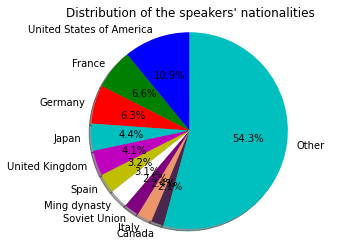

In [ ]:
total = proportion_nationality_1+proportion_nationality_2+ proportion_nationality_3 + proportion_nationality_4+proportion_nationality_5+proportion_nationality_6+proportion_nationality_7+proportion_nationality_8+proportion_nationality_9+proportion_nationality_10
rest = 1-total
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = nationality_1, nationality_2,nationality_3,nationality_4,nationality_5,nationality_6,nationality_7,nationality_8,nationality_9,nationality_10, 'Other'
sizes = [proportion_nationality_1, proportion_nationality_2, proportion_nationality_3, proportion_nationality_4, proportion_nationality_5, proportion_nationality_6, proportion_nationality_7, proportion_nationality_8, proportion_nationality_9, proportion_nationality_10, rest]
colors=['b', 'g', 'r', 'c', 'm', 'y', 'w', 'purple', '#ee966b', '#4a274f', 'c']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of the speakers' nationalities")

plt.show()

#### 2. Gender analysis

We decided to consider only the 5 most frequent genders in the database.

In [ ]:
list_of_genders = df_speakers['gender'].value_counts()
gender_1 = list_of_genders.index.tolist()[0][0]
gender_2 = list_of_genders.index.tolist()[1][0]
gender_3 = list_of_genders.index.tolist()[2][0]
gender_4 = list_of_genders.index.tolist()[3][0]
gender_5 = list_of_genders.index.tolist()[4][0]
gender_1 = wiki_quotation.filter(regex='{}$'.format(gender_1), axis = 0)['Label'][0]
gender_2 = wiki_quotation.filter(regex='{}$'.format(gender_2), axis = 0)['Label'][0]
gender_3 = wiki_quotation.filter(regex='{}$'.format(gender_3), axis = 0)['Label'][0]
gender_4 = wiki_quotation.filter(regex='{}$'.format(gender_4), axis = 0)['Label'][0]
gender_5 = wiki_quotation.filter(regex='{}$'.format(gender_5), axis = 0)['Label'][0]

nb_gender_1 = list_of_genders[0]
nb_gender_2 = list_of_genders[1]
nb_gender_3 = list_of_genders[2]
nb_gender_4 = list_of_genders[3]
nb_gender_5 = list_of_genders[4]

proportion_gender_1 = nb_gender_1/nb_speakers
proportion_gender_2 = nb_gender_2/nb_speakers
proportion_gender_3 = nb_gender_3/nb_speakers
proportion_gender_4 = nb_gender_4/nb_speakers
proportion_gender_5 = nb_gender_5/nb_speakers

print("The proportion of {} speakers overall is {:.3f}% with {} persons.".format(gender_1, proportion_gender_1*100, nb_gender_1))
print("The proportion of {} speakers overall is {:.3f}% with {} persons.".format(gender_2, proportion_gender_2*100, nb_gender_2))
print("The proportion of {} speakers overall is {:.3f}% with {} persons.".format(gender_3, proportion_gender_3*100, nb_gender_3))
print("The proportion of {} speakers overall is {:.3f}% with {} persons.".format(gender_4, proportion_gender_4*100, nb_gender_4))
print("The proportion of {} speakers overall is {:.3f}% with {} persons.".format(gender_5, proportion_gender_5*100, nb_gender_5))

The proportion of male speakers overall is 59.833% with 5418464 persons.
The proportion of female speakers overall is 18.597% with 1684170 persons.
The proportion of transgender female speakers overall is 0.010% with 887 persons.
The proportion of non-binary speakers overall is 0.003% with 307 persons.
The proportion of transgender male speakers overall is 0.003% with 228 persons.


We plot the distribution of female and male speakers (we considered that the other genders are in the 'other' category as it is a really low percentage).

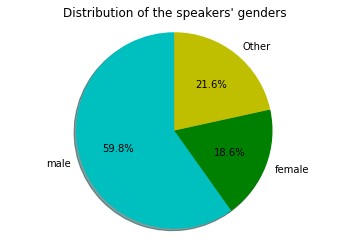

In [ ]:
total = proportion_gender_1+proportion_gender_2
rest = 1-total
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = gender_1,gender_2,'Other'
sizes = [proportion_gender_1, proportion_gender_2, rest]
colors=['c', 'g', 'y']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of the speakers' genders")

plt.show()

####3. Ethnic group analysis

We decided to only consider the persons who belong to at most two different ethnic groups in the same time as the number of speakers who belong to three or more ethnic-group is 177.

In [ ]:
df_ethn3 = pd.DataFrame()
df_ethn3['ethn']  = df_speakers['ethnic_group'].copy()
df_ethn3['ethn'] = df_ethn3['ethn'].apply(lambda ethn3: ethn3[2] if ethn3 is not None and len(ethn3) >= 3 else None)
nb_three_ethn_speakers = df_ethn3['ethn'].value_counts().sum()
print("There are", nb_three_ethn_speakers, "three-ethnic group belonging speakers.")

There are 177 three-ethnic group belonging speakers.


To get the different ethnic groups, we decided to create a new dataframe and split the rows with several ethnic-groups into different columns.

In [ ]:
df_ethnic = pd.DataFrame()

df_ethnic['ethnic'] = df_speakers['ethnic_group'].copy()
df_ethnic['ethnic1'] = df_speakers['ethnic_group'].copy()
df_ethnic['ethnic2'] = df_speakers['ethnic_group'].copy()

df_ethnic['ethnic1'] = df_ethnic['ethnic1'].apply(lambda ethnic1: ethnic1[0] if ethnic1 is not None and len(ethnic1) >= 1 else None)
df_ethnic['ethnic2'] = df_ethnic['ethnic2'].apply(lambda ethnic2: ethnic2[1] if ethnic2 is not None and len(ethnic2) >= 2 else None)

df_ethnic.drop("ethnic", axis=1, inplace=True)

df_ethnic.head()

,ethnic1,ethnic2
id,,
Q23,None,None
Q42,Q7994501,None
Q1868,None,None
Q207,None,None
Q297,None,None


The number of speakers for whom we know their ethnic group is the following:

In [ ]:
nb_speakers_with_ethn = df_ethnic['ethnic1'].value_counts().sum()
proportion = nb_speakers_with_ethn / nb_speakers
print("There are only", nb_speakers_with_ethn, "speakers for whom we know their ethnic group which means {:.2f}% of all the speakers.".format(proportion*100))

There are only 130385 speakers for whom we know their ethnic group which means 1.44% of all the speakers.


In [ ]:
df_ethnic_melt = df_ethnic.melt(var_name='columns', value_name='index')
list_ethnic = df_ethnic_melt['index'].value_counts()

ethnicity_1 = list_ethnic.index.tolist()[0]
ethnicity_2 = list_ethnic.index.tolist()[1]
ethnicity_3 = list_ethnic.index.tolist()[2]
ethnicity_4 = list_ethnic.index.tolist()[3]
ethnicity_5 = list_ethnic.index.tolist()[4]
ethnicity_6 = list_ethnic.index.tolist()[5]
ethnicity_7 = list_ethnic.index.tolist()[6]
ethnicity_8 = list_ethnic.index.tolist()[7]
ethnicity_9 = list_ethnic.index.tolist()[8]
ethnicity_10 = list_ethnic.index.tolist()[9]

ethnicity_1 = wiki_quotation.filter(regex='{}$'.format(ethnicity_1), axis = 0)['Label'][0]
ethnicity_2 = wiki_quotation.filter(regex='{}$'.format(ethnicity_2), axis = 0)['Label'][0]
ethnicity_3 = wiki_quotation.filter(regex='{}$'.format(ethnicity_3), axis = 0)['Label'][0]
ethnicity_4 = wiki_quotation.filter(regex='{}$'.format(ethnicity_4), axis = 0)['Label'][0]
ethnicity_5 = wiki_quotation.filter(regex='{}$'.format(ethnicity_5), axis = 0)['Label'][0]
ethnicity_6 = wiki_quotation.filter(regex='{}$'.format(ethnicity_6), axis = 0)['Label'][0]
ethnicity_7 = wiki_quotation.filter(regex='{}$'.format(ethnicity_7), axis = 0)['Label'][0]
ethnicity_8 = wiki_quotation.filter(regex='{}$'.format(ethnicity_8), axis = 0)['Label'][0]
ethnicity_9 = wiki_quotation.filter(regex='{}$'.format(ethnicity_9), axis = 0)['Label'][0]
ethnicity_10 = wiki_quotation.filter(regex='{}$'.format(ethnicity_10), axis = 0)['Label'][0]

We get the number of speakers with ethnic group (not considering speakers who have more than 2 ethnic groups) i.e for a two ethnic group speaker, it counts for 2 ethnic groups. We can see that it is a really low proportion.

In [ ]:
nb_ethnic = df_ethnic_melt['index'].value_counts().sum()
print("There are", nb_ethnic, "speakers with ethnic groups.")

There are 131701 speakers with ethnic groups.


In [ ]:
nb_ethnic_1 = list_ethnic[0]
nb_ethnic_2 = list_ethnic[1]
nb_ethnic_3 = list_ethnic[2]
nb_ethnic_4 = list_ethnic[3]
nb_ethnic_5 = list_ethnic[4]
nb_ethnic_6 = list_ethnic[5]
nb_ethnic_7 = list_ethnic[6]
nb_ethnic_8 = list_ethnic[7]
nb_ethnic_9 = list_ethnic[8]
nb_ethnic_10 = list_ethnic[9]

proportion_ethnic_1 = nb_ethnic_1/nb_ethnic
proportion_ethnic_2 = nb_ethnic_2/nb_ethnic
proportion_ethnic_3 = nb_ethnic_3/nb_ethnic
proportion_ethnic_4 = nb_ethnic_4/nb_ethnic
proportion_ethnic_5 = nb_ethnic_5/nb_ethnic
proportion_ethnic_6 = nb_ethnic_6/nb_ethnic
proportion_ethnic_7 = nb_ethnic_7/nb_ethnic
proportion_ethnic_8 = nb_ethnic_8/nb_ethnic
proportion_ethnic_9 = nb_ethnic_9/nb_ethnic
proportion_ethnic_10 = nb_ethnic_10/nb_ethnic


print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_1, proportion_ethnic_1*100, nb_ethnic_1))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_2, proportion_ethnic_2*100, nb_ethnic_2))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_3, proportion_ethnic_3*100, nb_ethnic_3))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_4, proportion_ethnic_4*100, nb_ethnic_4))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_5, proportion_ethnic_5*100, nb_ethnic_5))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_6, proportion_ethnic_6*100, nb_ethnic_6))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_7, proportion_ethnic_7*100, nb_ethnic_7))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_8, proportion_ethnic_8*100, nb_ethnic_8))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_9, proportion_ethnic_9*100, nb_ethnic_9))
print("The proportion of speakers who are from {} overall is {:.3f}% with {} persons.".format(ethnicity_10, proportion_ethnic_10*100, nb_ethnic_10))

The proportion of speakers who are from Han Chinese people overall is 28.610% with 37679 persons.
The proportion of speakers who are from African Americans overall is 14.469% with 19056 persons.
The proportion of speakers who are from Armenians overall is 8.686% with 11440 persons.
The proportion of speakers who are from Greeks overall is 4.003% with 5272 persons.
The proportion of speakers who are from Albanians overall is 3.080% with 4057 persons.
The proportion of speakers who are from Bulgarians overall is 2.750% with 3622 persons.
The proportion of speakers who are from Czechs overall is 2.273% with 2993 persons.
The proportion of speakers who are from Ukrainians overall is 2.211% with 2912 persons.
The proportion of speakers who are from Japanese people overall is 2.142% with 2821 persons.
The proportion of speakers who are from White Brazilian overall is 1.974% with 2600 persons.


We plot the distribution of the speakers ethnicities.

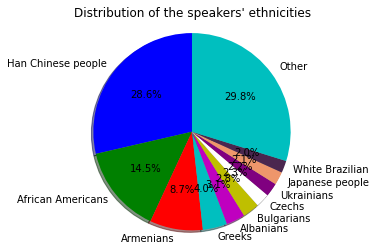

In [ ]:
total = proportion_ethnic_1+proportion_ethnic_2+ proportion_ethnic_3 + proportion_ethnic_4+proportion_ethnic_5+proportion_ethnic_6+proportion_ethnic_7+proportion_ethnic_8+proportion_ethnic_9+proportion_ethnic_10
rest = 1-total
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ethnicity_1, ethnicity_2,ethnicity_3,ethnicity_4,ethnicity_5,ethnicity_6,ethnicity_7,ethnicity_8,ethnicity_9,ethnicity_10, 'Other'
sizes = [proportion_ethnic_1, proportion_ethnic_2, proportion_ethnic_3, proportion_ethnic_4, proportion_ethnic_5, proportion_ethnic_6, proportion_ethnic_7, proportion_ethnic_8, proportion_ethnic_9, proportion_ethnic_10, rest]
colors=['b', 'g', 'r', 'c', 'm', 'y', 'w', 'purple', '#ee966b', '#4a274f', 'c']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of the speakers' ethnicities")

plt.show()

## Find topics of citations
We use BERTopic to classify the quotes in topics.

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(low_memory=True, calculate_probabilities=False, verbose=True)
path_bert_file = '/content/drive/MyDrive/ADA/bert.model'
path_bert_file_lazy = '/content/drive/MyDrive/ADA/bert_lazy.model'

### Fit the model
Either loading all the training set in memory

In [ ]:
training_set = qu["quotation"].sample(frac=0.01).compute()
topic_model = topic_model.fit(training_set.array)
topic_model.save(path_bert_file)

[########################################] | 100% Completed | 12min  1.5s


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1077 [00:00<?, ?it/s]

2021-11-12 20:34:22,433 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-11-12 20:35:29,148 - BERTopic - Reduced dimensionality with UMAP
2021-11-12 20:35:36,331 - BERTopic - Clustered UMAP embeddings with HDBSCAN


or keeping it lazy (much slower, but can train on bigger set)
*we still have an error here, bertopic seems not to be able to handle iterable*

In [ ]:
training_set_lazy = map(lambda tup: tup[1] or "", qu["quotation"].sample(frac=0.1).iteritems())
topic_model = topic_model.fit(training_set_lazy)


topic_model.save(path_bert_file_lazy)

[########################################] | 100% Completed | 23.3s
[########################################] | 100% Completed | 20.2s
[########################################] | 100% Completed | 22.6s
[########################################] | 100% Completed | 21.8s
[########################################] | 100% Completed | 22.3s
[########################################] | 100% Completed | 22.9s
[########################################] | 100% Completed | 21.4s
[########################################] | 100% Completed | 22.1s
[########################################] | 100% Completed | 22.6s
[########################################] | 100% Completed | 22.2s
[########################################] | 100% Completed | 22.3s
[########################################] | 100% Completed | 23.5s
[########################################] | 100% Completed | 19.6s
[########################################] | 100% Completed | 24.4s
[########################################] | 100

TypeError: ignored

#### Let's see the labels found by bert
Here we provide some visualisations of the topics found by bert in the training sample.

In [ ]:
topic_model.load(path_bert_file)
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,18330,-1_him_health_work_game
1,0,1894,0_business_market_customers_businesses
2,1,719,1_she_her_shes_herself
3,2,599,2_player_him_plays_play
4,3,505,3_students_schools_education_student
...,...,...,...
267,266,10,266_smell_communication_pickpockets_booze
268,267,10,267_family_lost_godmother_kendreen
269,268,10,268_cry_crying_tears_susans
270,269,10,269_design_designs_custom_layouts


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_hierarchy()

### Compute labels
*this is too slow, we'll need a more efficient way to do this, maybe doing whole partition at the same time*

In [ ]:
topic_model.load(path_bert_file)
qu = qu.assign(topics=0)
def calculate_topics(row):
  topics, probs = topic_model.transform(row.quotation)
  row.topics = topics
qu = qu.apply(calculate_topics, axis=1)
qu.head()

# Compare With Some Real World Data

## Dow Jones Analysis
We want to analyse some data of the Dow Jones for the same time as the quotes we have from Quotebank.

In [ ]:
# First we load the data in a DataFrame, and make a copy to apply modifications safely.
path_dow_jone_file = '/content/drive/MyDrive/ADA/USA30IDXUSD_D1.csv'

dj_raw = pd.read_csv(path_dow_jone_file, sep='\t')

dj = dj_raw.copy()

In [ ]:
# We get some infos about the dataset, and a first glimpse of what the data looks like with head().

display(dj.info())
print('\n')
display(dj.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438 entries, 0 to 2437
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    2438 non-null   object 
 1   Open    2438 non-null   float64
 2   High    2438 non-null   float64
 3   Low     2438 non-null   float64
 4   Close   2438 non-null   float64
 5   Volume  2438 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 114.4+ KB


None

,Time,Open,High,Low,Close,Volume
0,2013-05-23 00:00:00,15343.0,15353.0,15155.0,15328.0,1374
1,2013-05-24 00:00:00,15328.0,15345.0,15311.0,15322.0,225
2,2013-05-26 00:00:00,15313.0,15359.0,15313.0,15331.0,117
3,2013-05-27 00:00:00,15331.0,15347.0,15281.0,15334.0,1005
4,2013-05-28 00:00:00,15334.0,15522.0,15332.0,15391.0,1372


The data comes from https://forexsb.com/historical-forex-data, and represents the value of the Dow Jones through time.

TODO : explain the different attributes Open, High, Low, Close, Volume and choose the most adapted one to plot. Possibly explain why it does not change much which attribute we choose.

In [ ]:
# We check the type of the dates.

print('The type of the dates is ', type(dj['Time'][0]))

The type of the dates is  <class 'str'>


In [ ]:
# We change the type of the dates so it's more convenient to handle and to visualise when plotting.

dj['Time'] = pd.to_datetime(dj['Time'], yearfirst=True)
print('The type of the dates is ', type(dj['Time'][0]))

The type of the dates is  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


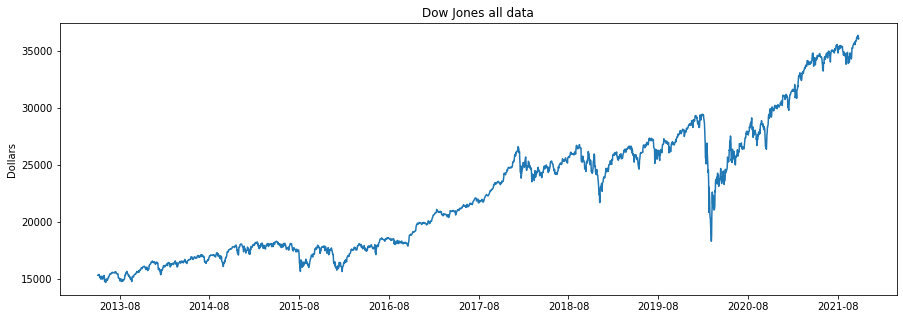

In [ ]:
# We plot the whole data set.

plt.figure(figsize=(15, 5))

ax = plt.gca()

formatter = mdates.DateFormatter("%Y-%m")

ax.xaxis.set_major_formatter(formatter)

locator = mdates.DayLocator(interval=365)

ax.xaxis.set_major_locator(locator)

plt.title('Dow Jones all data')
plt.ylabel('Dollars')
plt.plot(dj['Time'], dj['Close'])

In [ ]:
# We check minimum and maximum values.

min_ = dj['Time'].min()
max_ = dj['Time'].max()

display(min_)
display(max_)

Timestamp('2013-05-23 00:00:00')

Timestamp('2021-11-11 00:00:00')

We see that the data goes from May 23rd of 2013 until November 11th of 2021. Since the quotes we have from Quotebank go from 2015 to 2020 (included), we decided to keep the data from 2015 to 2020 only.

In [ ]:
# We truncate the data to keep only the relevant one.

dj = dj[(dj['Time'] >= '2015-01-01') & (dj['Time'] <= '2020-12-31')]

In [ ]:
# We check minimum and maximum values.

min_ = dj['Time'].min()
max_ = dj['Time'].max()

display(min_)
display(max_)

Timestamp('2015-01-02 00:00:00')

Timestamp('2020-12-31 00:00:00')

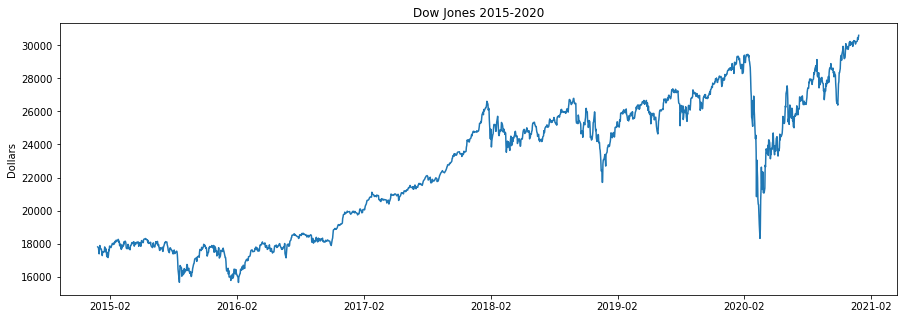

In [ ]:
# We plot again, this time truncated from 2015 to 2020 (included).

plt.figure(figsize=(15, 5))

ax = plt.gca()

formatter = mdates.DateFormatter("%Y-%m")

ax.xaxis.set_major_formatter(formatter)

locator = mdates.DayLocator(interval=365)

ax.xaxis.set_major_locator(locator)

plt.title('Dow Jones 2015-2020')
plt.ylabel('Dollars')
plt.plot(dj['Time'], dj['Close'])

In [ ]:
# We create a column Deriv1 showing the difference of the value from one day to the next, namely the first derivative of the Dow Jones.

dj['Deriv1'] = dj['Close'].diff()

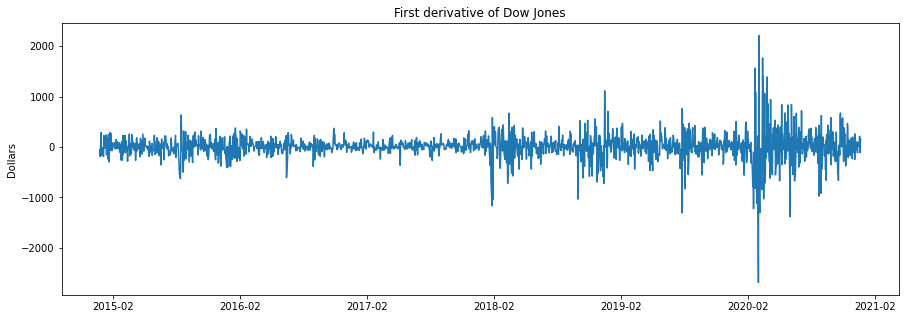

In [ ]:
# We plot the first derivative.

plt.figure(figsize=(15, 5))

ax = plt.gca()

formatter = mdates.DateFormatter("%Y-%m")

ax.xaxis.set_major_formatter(formatter)

locator = mdates.DayLocator(interval=365)

ax.xaxis.set_major_locator(locator)

plt.title('First derivative of Dow Jones')
plt.ylabel('Dollars')
plt.plot(dj['Time'], dj['Deriv1'])

In [ ]:
# We get the second derivative, to grasp rapid variations that do not last long.

dj['Deriv2'] = dj['Deriv1'].diff()

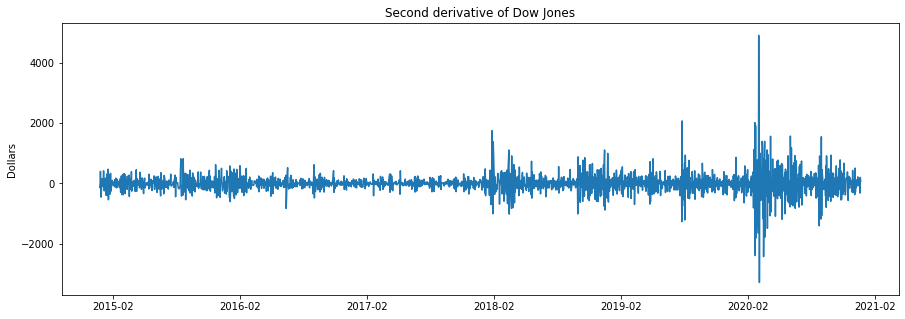

In [ ]:
# We plot the second derivative.

plt.figure(figsize=(15, 5))

ax = plt.gca()

formatter = mdates.DateFormatter("%Y-%m")

ax.xaxis.set_major_formatter(formatter)

locator = mdates.DayLocator(interval=365)

ax.xaxis.set_major_locator(locator)

plt.title('Second derivative of Dow Jones')
plt.ylabel('Dollars')
plt.plot(dj['Time'], dj['Deriv2'])